In [1]:
# Import required packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import support_functions  # Helper functions

# Challenge: COVID-19 classification based on CT scan

The **COVID-19** pandemic has changed lives around the world. This is the current situation as of 2020/09/14.
![current situation](../img/covid-19-pandemic.png) 

## What's the challenge?

**Computed tomography (CT) scans** have been used for screening and diagnosing COVID-19, especially in areas where swab test resources are severely lacking. The goal of the 2020 INFORMS [QSR Data Challenge](https://connect.informs.org/HigherLogic/System/DownloadDocumentFile.ashx?DocumentFileKey=f404f7b8-fcd6-75d5-f7a7-d262eab132e7) is to diagnose COVID-19 using the chest CT scans.

Therefore, the challenge is to come up with a **classification model** that classify patients to COVID or NonCOVID based on their chest CT scans, **as accurately as possible**.

## What's provided?

- Training data set
    - 251 COVID-19 CT images
    - 292 non-COVID-19 CT images
- Meta-information
    - e.g., patient information, severity, image caption
    
All of data are taken from a [public data set](https://github.com/UCSD-AI4H/COVID-CT).

# Load data

We first load the provided training images from folders.  
Loading is taken care of by `read_ct_scan` function.

In [2]:
# Get public covid, noncovid and normal images
base_path = os.path.join(os.getcwd(), '..', 'data', 'training-images')

noncovid_images = support_functions.read_ct_scan(os.path.join(base_path, 'CT_NonCOVID'))
covid_images = support_functions.read_ct_scan(os.path.join(base_path, 'CT_COVID'))

print('Total number of images: ')
print('COVID: ', len(noncovid_images))
print('NonCOVID: ', len(covid_images))

Total number of images: 
COVID:  292
NonCOVID:  251


Let's have a look at some noncovid and covid CT scans.

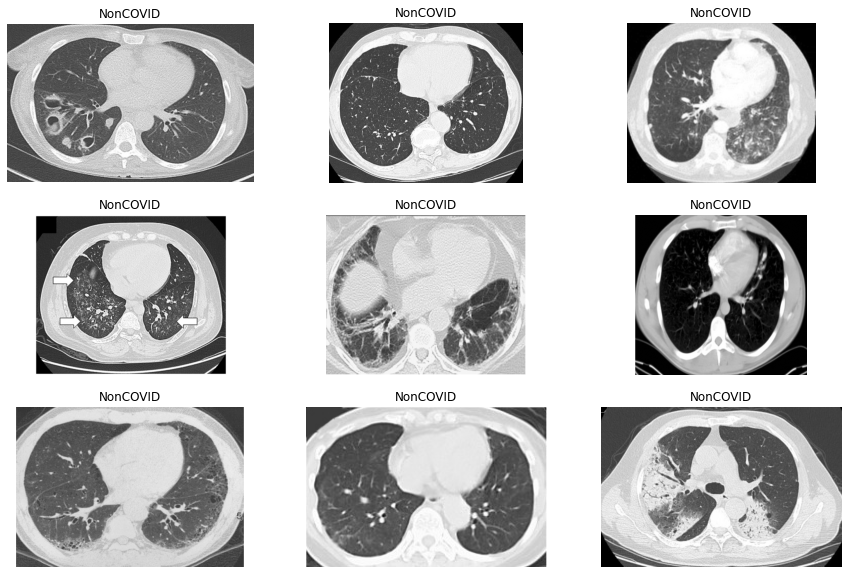

In [3]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(noncovid_images[i]/255.)
    plt.axis("off")
    plt.title('NonCOVID')

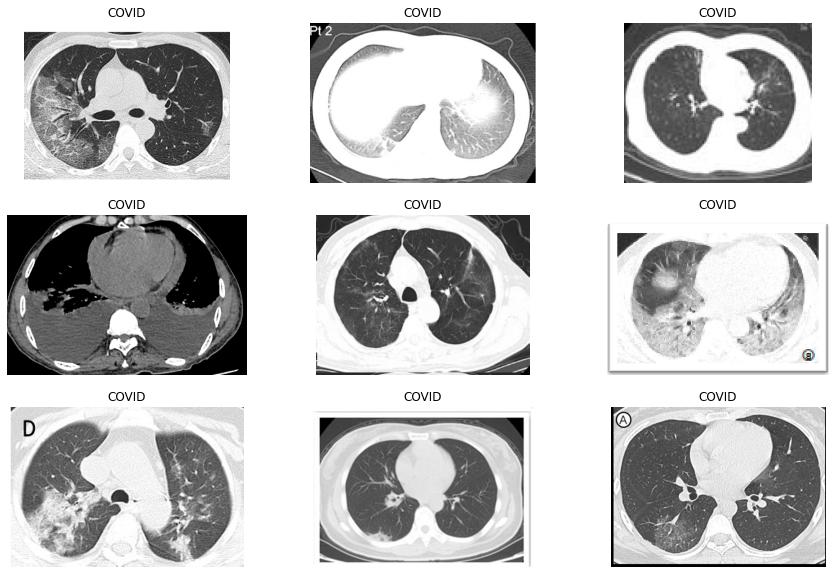

In [4]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(covid_images[i]/255.)
    plt.axis("off")
    plt.title('COVID')

# Set up data for training

Let's create binary training labels for our covid and noncovid images, that is

- Noncovid: 0
- Covid: 1

The labels are required for our supervised classification task.

In [5]:
noncovid_labels = np.full(len(noncovid_images),fill_value=0)
covid_labels = np.full(len(covid_images),fill_value=1)

## Train-validation split

Here we reserve 20% of the data for validation. 

Note that, since some consecutive images may come from the same patient, they tend to be similar to each other.  
That is, our data is **not independent**.  

To prevent data leakage (information of training data spills over to validation data), we keep the original image sequence and hold out the last 20% as the validation set. 

After the splitting, we have two pairs of data:
1. `X_train`, `y_train`
2. `X_val`, `y_val`

X is a list of CT scans, and y is a list of binary labels.

In [6]:
# Train-validation split while keeping the order of the images
train_data_portion = 0.8 # Proportion of data for training

# Get integer number of training samples
train_covid_size = round(len(covid_images)*train_data_portion)
train_noncovid_size = round(len(noncovid_images)*train_data_portion)

# Split the dataset in its original sequence
X_train = noncovid_images[:train_noncovid_size] + covid_images[:train_covid_size]
y_train = np.concatenate((noncovid_labels[:train_noncovid_size], 
                          covid_labels[:train_covid_size]))

X_val = noncovid_images[train_noncovid_size:] + covid_images[train_covid_size:]
y_val = np.concatenate((noncovid_labels[train_noncovid_size:], 
                        covid_labels[train_covid_size:]))

print('Train-validation split:')
print('{} training images and {} validation images'.format(len(X_train), len(X_val)))

Train-validation split:
435 training images and 108 validation images


## Create `tf.data.Dataset` object

We create two `tf.data.Dataset` objects, one for training and the other for validation. 

The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. Essentially, it is a tensorflow data structure that greatly simplifies some essential operations, for example, preprocessing, shuffling and training.  
You can read more about it [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

In the `resize_and_shuffle` function, we 
1. create a `Dataset` object from a (`X, y`) pair,
2. resize each image to a standard size,
3. shuffle and split the data into batches for training later.

In [7]:
# Define global variables
IMG_SIZE = (256,256) # Standardize all images to this size
BATCH_SIZE = 32 # Number of training images for each gradient update
RANDOM_SEED = 123 # Random seed to ensure reproducibility

# Create training and validation Dataset objects
train_ds = support_functions.resize_and_shuffle(X_train, y_train, img_size=IMG_SIZE)
val_ds = support_functions.resize_and_shuffle(X_val, y_val, img_size=IMG_SIZE)

Since we have 435 training images, with a batch size of 32, we expect to get 14 batches of data. You can verify this by running the next cell.

In [8]:
train_ds.cardinality().numpy()

14

## Data augmentation

Here we use `tf.keras.Sequential` to create a pipeline in which the input image is randomly transformed through the following operations:
1. Random horizontal and vertical flip
2. Rotation by a random degree in the range of $[-5\%, 5\%]*2\pi$
3. Random zoom in height by $5\%$
4. Random translation by $5\%$
5. Random contrast adjustment by $5\%$

In [9]:
# Create data augmentation pipeline
augmentation_pipeline = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomRotation((-0.05, 0.05), seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomZoom(-0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomContrast(0.05, seed=RANDOM_SEED),
    ]
)

# Augment training data using augmentation pipeline
augmented_train_ds = train_ds.map(
    lambda x, y: (augmentation_pipeline(x, training=True), y))
train_ds = augmented_train_ds

**Be careful not to run the previous cell more than once as it will keep transforming the data.**  
If you have done so, you can rerun from "Create `tf.data.Dataset`" section to get the original data.

Let's see the effect of data augmentation.

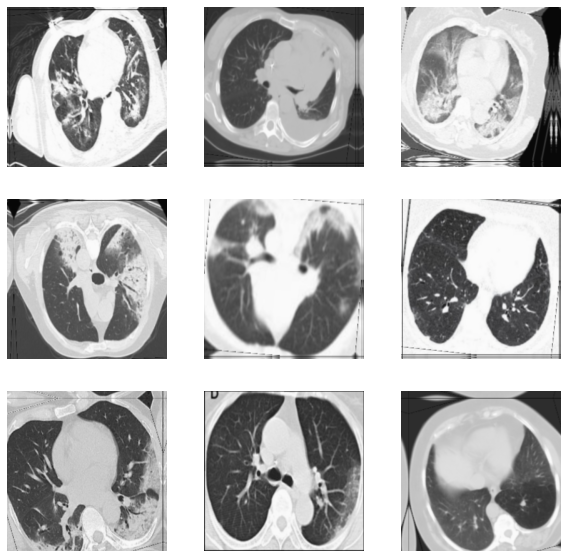

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]/255.)
        plt.axis("off")

In [11]:
# Prefetching the data.
# This is just an operation which speeds up the training process.
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

**Just a quick recap, we've done these so far:**
1. Loaded images from the folder.
2. Split data into two data sets: training and validation.
3. Randomly perturbed training images through an augmentation pipeline.

Now we are ready to make a CNN model for our classification task.

# Build CNN model

## Load pre-trained model

We first import a pre-trained CNN model and use it as our model backbone. 

The chosen model is [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) and it belongs to the family of models called [EfficientNets](https://arxiv.org/abs/1905.11946) proposed by reseachers from Google.  
EfficientNets are among the current state-of-the-art CNNs for computer vision tasks. They
1. require considerably lower number of parameters
2. achieved very high accuracies on ImageNet
3. transferred well to other image classification tasks. 

Here's a performance comparison between EfficientNets and other well-known models:![EfficientNet](../img/efficientnets.png)

* EfficientNets, and other well-known pre-trained models, can be easily loaded from `tf.keras.applications`. 
* We specify the input image shape and remove the weights for the last classification layer. 
* Also, we freeze the model's weights so that they won't be updated during the initial training.

In [12]:
IMG_SHAPE = IMG_SIZE + (3,) # Add a third dimension for RGB channel

# Create a base model from the pre-trained EfficientNetB0
base_model = keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

## Wrap our model around it

Here we wrap our classification model around the base model imported above. The final model has
1. An input layer 
2. **EfficientNetB0 base model**
3. An average pooling layer: pool the information by average operation
4. A dropout layer: set a percentage of inputs to zero
5. A classification layer: outputs the probability of NonCovid

In [13]:
inputs = keras.Input(shape=IMG_SHAPE) # Input layer

x = base_model(inputs) # EfficientNetB0
x = layers.GlobalAveragePooling2D()(x) # Pooling layer
x = layers.Dropout(0.1)(x) # Dropout layer

outputs = layers.Dense(1, activation="sigmoid")(x) # Classification layer

# Build the model
model = keras.Model(inputs, outputs) 

## Visualize the model

Let's take a look at our model's summary. We can see that:
1. The input layer has the correct image dimension of (256, 256, 3).
2. The `None` in output shape is a reserved place for the number of samples, which the model does not know yet.
2. EfficientNetB0 sits right after the input layer.
3. The last (classification) layer has output of dimension 1: NonCovid probability.
3. Most importantly, since we've frozen the parameters of EfficientNetB0, the number of trainable parameters is only 1281. 

In [14]:
# Print out a summary of the model created.
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


We can also use `tf.keras.utils.plot_model` to visualize the model that we've just created. 

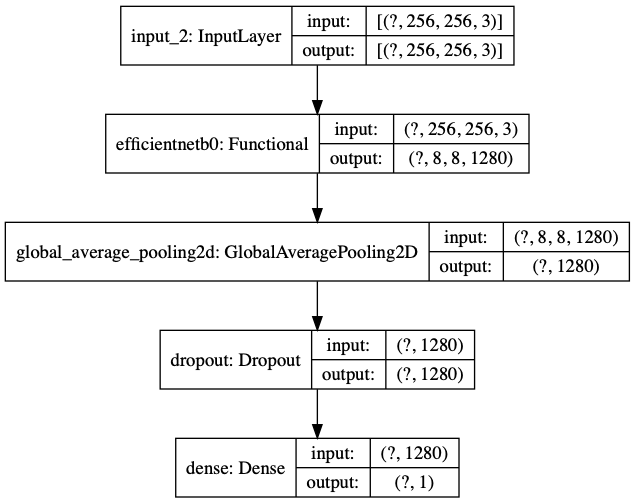

In [15]:
# Plot the model layers' dependency graph and each layer's input-output shape.
keras.utils.plot_model(model, show_shapes=True)

**Transfer learning**:
To help EfficientNets adapt to covid vs noncovid image classification task, we've actually trained our model on another public CT scan data set. The hope is that training the model on CT scans would allow it to learn features specific to our covid classification task. 

Here we will not go into the public data training part, and just **load the public data trained model's weights** onto the model that we've just created.

In [16]:
# Load pre-trained model weights
# expect_partial() tells the function that we are only loading the weights, not the whole training history
model.load_weights(os.path.join('..', 'saved_weights', 'pre_trained_weights')).expect_partial()

# Train CNN model

Good! Now we are ready to train our model on the actual challenge data. We are going to use the typical transfer-learning workflow:
1. Phase 1: Fix EfficientNets' weights, only update the last classification layer's weights.
2. Phase 2: Fine tuning. Allow some of EfficientNets' weights to update as well.

You can read more about the workflow [here](https://www.tensorflow.org/guide/keras/transfer_learning#the_typical_transfer-learning_workflow).

Let's define some key variables for the training process:
1. **Metrics**: to evaluate our model
    - Binary accuracy
    - False and true positives
    - False and true negatives
2. **Loss**: to guide gradient search
    - Binary crossentropy
3. **Optimizer**: the actual optimization algorithm
3. **Learning rates**: One for each phase
4. **Training epochs**: One for each phase

In [17]:
# Specify metrics, loss function, and optimizer 
metrics =[keras.metrics.BinaryAccuracy(), keras.metrics.FalsePositives(),
            keras.metrics.TruePositives(), keras.metrics.FalseNegatives(),
            keras.metrics.TrueNegatives()]
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam

# Create learning rates for two phases of training 
learning_rates = [1e-3, 1e-4]

- **Here we set training epochs to 10 and 30 just for illustration.**
- You can change the number of epochs to [1, 1] and get a feel of the training process.
- Note that each epoch takes about 30-40s to run. 

In [18]:
# Setting the number of training epochs
training_epochs = [10, 30]  

## Phase 1: EfficientNets fixed

In [19]:
# Phase 1: EfficientNets'weights fixed

# Compile the model
model.compile(
    optimizer=optimizer(learning_rates[0]),
    loss=loss,
    metrics=metrics,
)

# Train the model
phase_1_history = model.fit(
    train_ds, 
    epochs=training_epochs[0], 
    validation_data=val_ds
)

Epoch 1/10
14/14 [==============================] - 38s 3s/step - loss: 0.8147 - binary_accuracy: 0.4552 - false_positives: 185.0000 - true_positives: 149.0000 - false_negatives: 52.0000 - true_negatives: 49.0000 - val_loss: 0.8178 - val_binary_accuracy: 0.4815 - val_false_positives: 52.0000 - val_true_positives: 46.0000 - val_false_negatives: 4.0000 - val_true_negatives: 6.0000
Epoch 2/10
14/14 [==============================] - 35s 2s/step - loss: 0.8094 - binary_accuracy: 0.4759 - false_positives: 180.0000 - true_positives: 153.0000 - false_negatives: 48.0000 - true_negatives: 54.0000 - val_loss: 0.8171 - val_binary_accuracy: 0.4907 - val_false_positives: 51.0000 - val_true_positives: 46.0000 - val_false_negatives: 4.0000 - val_true_negatives: 7.0000
Epoch 3/10
14/14 [==============================] - 44s 3s/step - loss: 0.8104 - binary_accuracy: 0.4759 - false_positives: 182.0000 - true_positives: 155.0000 - false_negatives: 46.0000 - true_negatives: 52.0000 - val_loss: 0.8166 - va

Let's see the training history by plotting out:
1. Loss
2. Accuracy
3. Type I error
4. Type II error

This is done through two helper functions: `get_metric_history` and `plot_metric_history`.

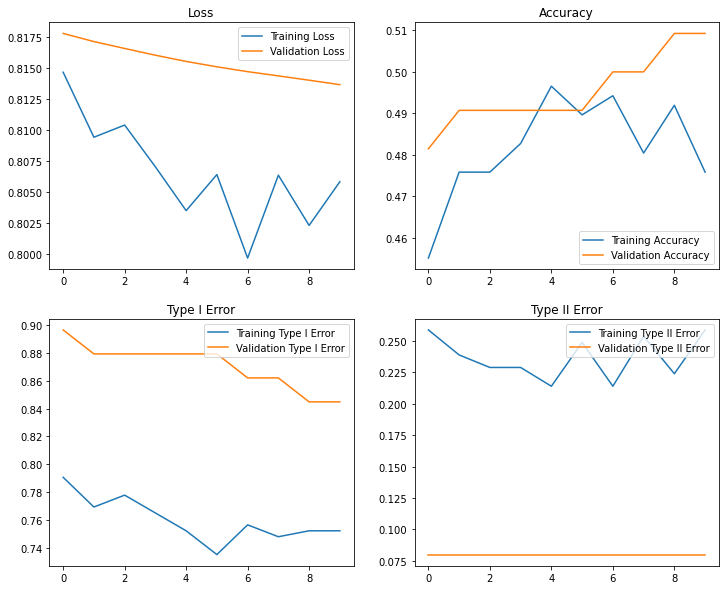

In [20]:
# Extract training history of phase 1
phase_1_metrics = support_functions.get_metric_history(phase_1_history)

# Visualize the training history of phase 1
support_functions.plot_metric_history(phase_1_metrics)

## Phase 2: Fine tuning

Now let's unfreeze some layers of EfficientNets and allow them to be trained with data. This is done by setting the layer's `trainable` attribute to `True`.

In [21]:
# Phase 2: Fine tuning
base_model.trainable = True

# We only update parameters from layer 221 onwards
fine_tune_at = 221
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False 

In [22]:
# Since we've changed the attribute of the base model
# we need to compile the model again to capture this change.
model.compile(
    optimizer=optimizer(learning_rates[1]), 
    loss=loss,
    metrics=metrics
)

# Train the model
phase_2_history = model.fit(
    train_ds,
    epochs=sum(training_epochs),
    initial_epoch=phase_1_history.epoch[-1], 
    validation_data = val_ds
)

Epoch 10/40
14/14 [==============================] - 36s 3s/step - loss: 0.7426 - binary_accuracy: 0.5414 - false_positives: 152.0000 - true_positives: 154.0000 - false_negatives: 97.0000 - true_negatives: 140.0000 - val_loss: 0.7910 - val_binary_accuracy: 0.5278 - val_false_positives: 45.0000 - val_true_positives: 44.0000 - val_false_negatives: 6.0000 - val_true_negatives: 13.0000
Epoch 11/40
14/14 [==============================] - 30s 2s/step - loss: 0.7210 - binary_accuracy: 0.5793 - false_positives: 92.0000 - true_positives: 110.0000 - false_negatives: 91.0000 - true_negatives: 142.0000 - val_loss: 0.7754 - val_binary_accuracy: 0.5648 - val_false_positives: 42.0000 - val_true_positives: 45.0000 - val_false_negatives: 5.0000 - val_true_negatives: 16.0000
Epoch 12/40
14/14 [==============================] - 31s 2s/step - loss: 0.6924 - binary_accuracy: 0.6506 - false_positives: 74.0000 - true_positives: 123.0000 - false_negatives: 78.0000 - true_negatives: 160.0000 - val_loss: 0.757

Let's visualize the training history again by combing both phases.

Here you can see that after we've allowed some layers of EfficientNets to update (after Epoch 10), we get a significant improvement in classification accuracy. 

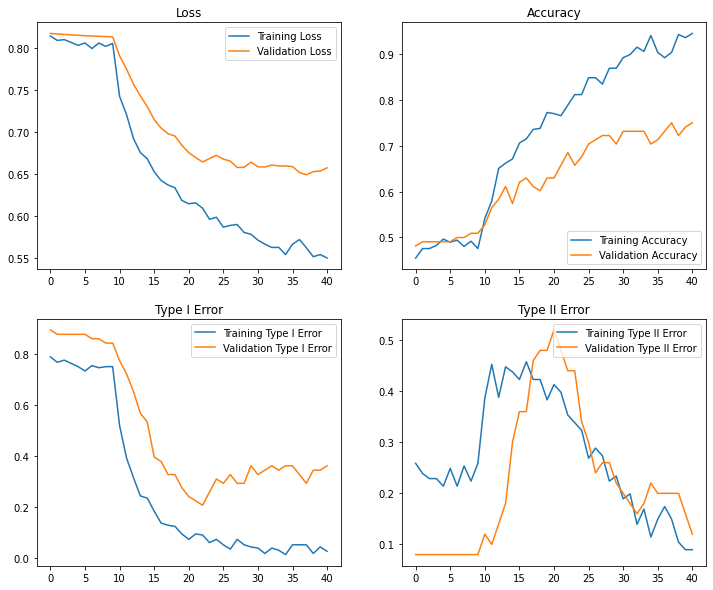

In [23]:
# Extract training history of phase 2
phase_2_metrics = support_functions.get_metric_history(phase_2_history)

# Combine the training history of phase 1 and 2
combined_metrics = [metric_1 + metric_2 for metric_1, metric_2 in zip(phase_1_metrics, phase_2_metrics)]

# Visualize the complete training history
support_functions.plot_metric_history(combined_metrics)

# Model performance

Let's take a look at the final model's performance. 

We are loading a model that is defined exactly as before, but trained with slightly more epochs. 

In [24]:
# Defining path to the trained model
path_to_trained_model = os.path.join(os.path.curdir, '..', 'saved_model', 'trained_model.h5')

# Load the trained model
trained_model = keras.models.load_model(path_to_trained_model)

- We can double check that this loaded model has exactly the same architecture as defined before. 
- Note also that the number of trainable parameters is 1,130,673, since we've updated some of EfficientNets' layers.

In [25]:
trained_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,130,673
Non-trainable params: 2,920,179
_________________________________________________________________


## Load test data

Let's load the test data from the folder and create labels for them.

There are 
- 105 NonCOVID images
- 98 COVID images

In [26]:
path_to_test_data = os.path.join(os.path.curdir, '..', 'data', 'testing-images')

noncovid_test = support_functions.read_ct_scan(os.path.join(path_to_test_data, 'CT_NonCOVID'))
covid_test = support_functions.read_ct_scan(os.path.join(path_to_test_data, 'CT_COVID'))

X_test = noncovid_test + covid_test
y_test = np.concatenate(
    (
        np.full(len(noncovid_test),fill_value='NonCOVID'), 
        np.full(len(covid_test),fill_value='COVID')
    )
)

## Make predictions on test data

- We first define a `prediction` function that makes predictions on new images using the trained model.
- Don't try to read it, it's just a helper function.

In [27]:
# Prediction function that takes in a list of images and a trained model
# and returns a list of predictions.
def predict(X_test,model): 
    results = list(map(lambda img: tf.image.resize(img, (256, 256)), X_test))
    resized_X = tf.data.Dataset.from_tensor_slices(results).batch(32)
    prediction = model.predict(resized_X)

    return prediction, support_functions.label_predictions(prediction)

In [28]:
# Make prediction on test data using the trained model.
# We get the predicted NonCovid probabilities and the predicted labels.
pred_probs, y_pred = predict(X_test, trained_model)

Let's see the result in a **confusion matrix**.

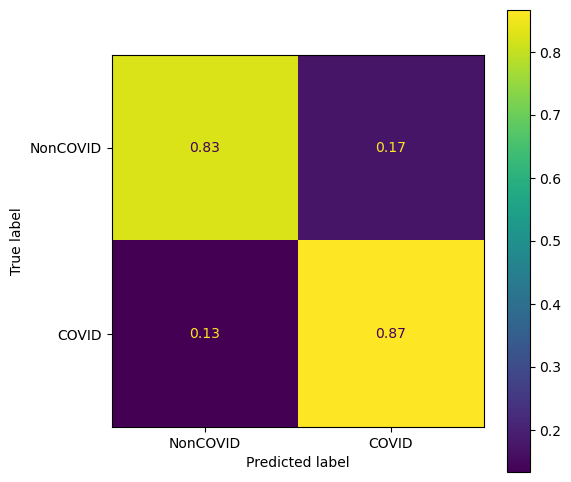

In [29]:
display_labels = ['NonCOVID', 'COVID']

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), 
    display_labels=display_labels
)

with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=[6,6])
    disp.plot(include_values=True, xticks_rotation='horizontal', ax=ax);

Let's also draw the model's **ROC curve**.

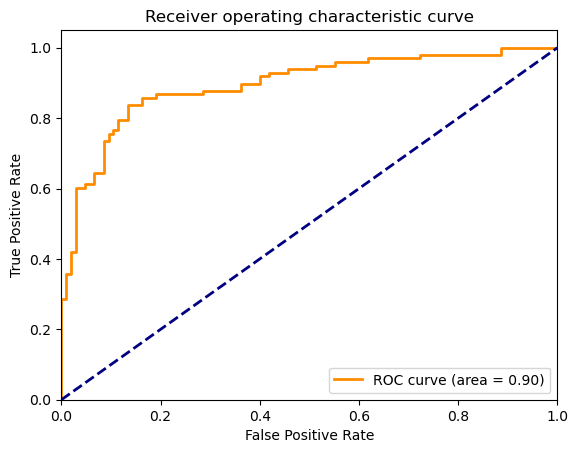

In [30]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, pred_probs, pos_label='COVID')
roc_auc = auc(fpr, tpr)

with plt.style.context('default'):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

## What are the correctly classified CT scans?

We can also dive into the classification result and see which are the ones identified correctly, and which are identified incorrectly. 

**Potential patterns** found could be leveraged to help further improve the model.  
Let's plot some of the correctly identified CT scans:
1. True positives
2. True negatives

**Could you identify some patterns?**

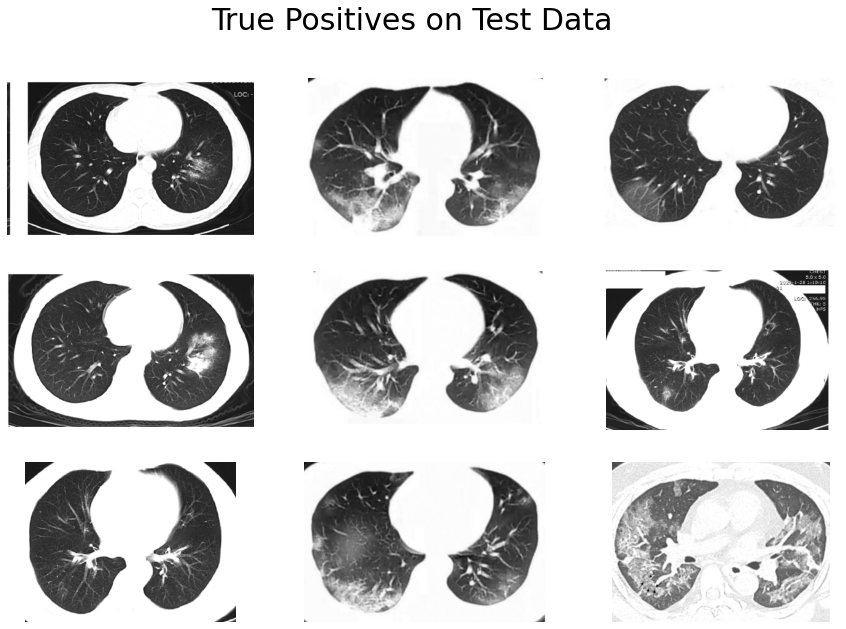

In [31]:
true_pos_test = np.array(X_test[105:])[y_pred[105:] == y_test[105:]]

plt.figure(figsize=(15, 10))
for i in range(min(9, len(true_pos_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(true_pos_test[i])
    plt.axis("off")
plt.suptitle('True Positives on Test Data', fontsize=30);

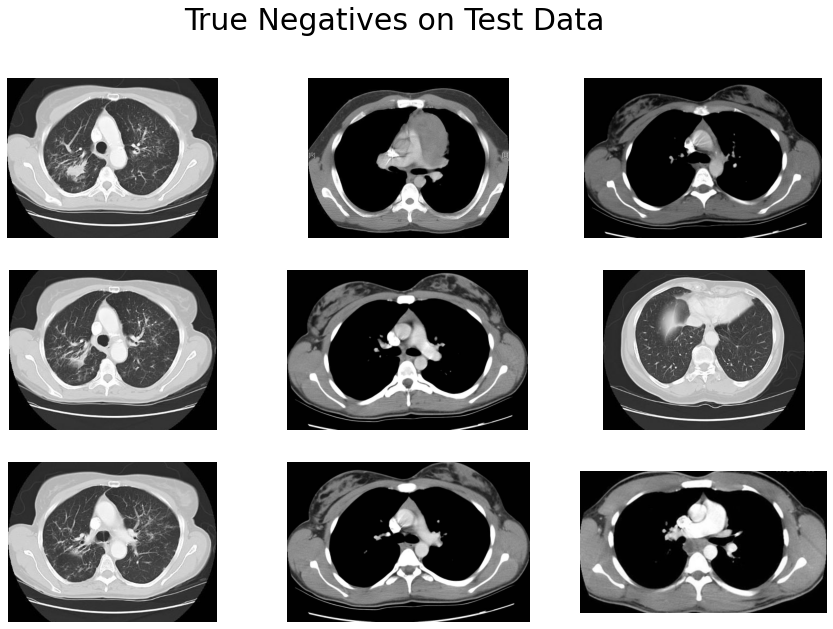

In [32]:
true_neg_test = np.array(X_test[:105])[y_pred[:105] == y_test[:105]]

plt.figure(figsize=(15, 10))
for i in range(min(9, len(true_neg_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(true_neg_test[i])
    plt.axis("off")
plt.suptitle('True Negatives on Test Data', fontsize=30);

## What are the misclassified CT scans?

Let's also plot some misclassified CT scans:
1. False positives
2. False negatives

**Could you identify some patterns?**

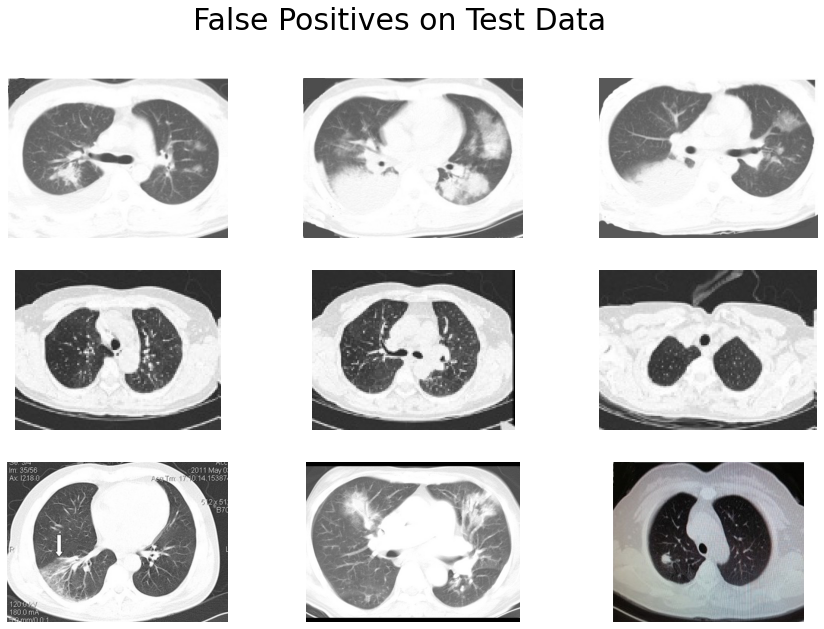

In [33]:
false_pos_test = np.array(X_test[:105])[y_pred[:105] != y_test[:105]]

plt.figure(figsize=(15, 10))
for i in range(min(9, len(false_pos_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(false_pos_test[i])
    plt.axis("off")
plt.suptitle('False Positives on Test Data', fontsize=30);

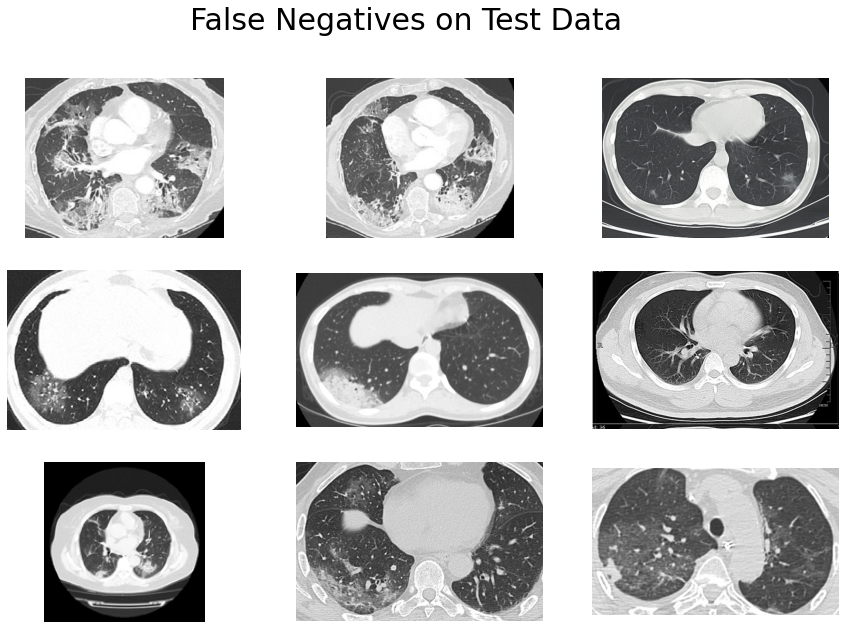

In [34]:
false_neg_test = np.array(X_test[105:])[y_pred[105:] != y_test[105:]]

plt.figure(figsize=(15, 10))
for i in range(min(9, len(false_neg_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(false_neg_test[i])
    plt.axis("off")
plt.suptitle('False Negatives on Test Data', fontsize=30);

# Summary

There are several directions for which we could make the model better:

1. **Lung segmentation**: Process each image and retain only the lung area of the CT scan, for example, see [here](https://pubs.rsna.org/doi/full/10.1148/rg.2015140232).
2. More sophisticated **transfer learning** design: For example, see [multi-task learning](https://ruder.io/multi-task/) or [supervised domain adaptation](https://en.wikipedia.org/wiki/Domain_adaptation#The_different_types_of_domain_adaptation). 
3. **Ensemble** model: This seems like a common belief, especially among Kaggle users, that building an [ensemble model](https://scikit-learn.org/stable/modules/ensemble.html) would almost always give you extra few percent increase in accuracy. 

*That's it for our CNN COVID-19 CT scan classification! Thank you!* 👏👏👏